# Stock Analysis & Sharia Compliance Chat Interface

This notebook implements a comprehensive Gradio-based chat interface for stock analysis and Islamic Sharia compliance checks. It provides:

- **Real-time Stock Data Fetching** using yfinance
- **Technical Analysis** with multiple time periods
- **AI-Powered Trade Recommendations** using OpenAI GPT-4o-mini
- **Sharia Compliance Assessment** for Islamic investing
- **Interactive Charts** and user-friendly interface

## Features
1. Multi-period stock analysis (1 month, 1 year, 5 years)
2. Automated trade advice (BUY/HOLD/SELL) with justification
3. Sharia compliance ruling with confidence scores
4. Interactive price charts
5. Clean Gradio chat interface


## 1. Imports

First, let's import all necessary libraries and set up our environment.


In [1]:
# Core imports
import os
import json
import warnings
from dotenv import load_dotenv

warnings.filterwarnings('ignore')

# Data and analysis
import yfinance as yf
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Web scraping for company info
import requests
from bs4 import BeautifulSoup

# AI and interface
import openai
import gradio as gr

# Load OpenAI API key from environment
load_dotenv(override=True)
openai.api_key = os.getenv('OPENAI_API_KEY')

if not openai.api_key:
    print("⚠️ Warning: OPENAI_API_KEY not found in environment variables")
    print("Please set your OpenAI API key: export OPENAI_API_KEY='your-key-here'")
else:
    print("✅ OpenAI API key loaded successfully")

print("🚀 All libraries imported successfully!")


✅ OpenAI API key loaded successfully
🚀 All libraries imported successfully!


## 2. Data Fetching Tool

This function fetches historical stock data using yfinance for any given symbol, period, and interval.


In [2]:
def fetch_history(symbol, period="1mo", interval="1d"):
    """
    Fetch historical stock data using yfinance
    
    Args:
        symbol (str): Stock ticker symbol (e.g., 'AAPL', 'MSFT')
        period (str): Time period ('1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max')
        interval (str): Data interval ('1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo')
    
    Returns:
        pandas.DataFrame: Historical stock data with OHLCV columns
    """
    try:
        # Create ticker object
        ticker = yf.Ticker(symbol)
        
        # Fetch historical data
        df = ticker.history(period=period, interval=interval)
        
        if df.empty:
            raise ValueError(f"No data found for symbol: {symbol}")
        
        print(f"✅ Successfully fetched {len(df)} data points for {symbol} ({period})")
        return df
        
    except Exception as e:
        print(f"❌ Error fetching data for {symbol}: {str(e)}")
        return pd.DataFrame()

# Test the function
test_symbol = "ABUK.CA"
test_data = fetch_history(test_symbol, "1mo", "1d")
if not test_data.empty:
    print(f"\n📊 Sample data for {test_symbol}:")
    print(test_data.head())


✅ Successfully fetched 17 data points for ABUK.CA (1mo)

📊 Sample data for ABUK.CA:
                                Open       High        Low      Close  \
Date                                                                    
2025-06-22 00:00:00+03:00  45.970001  47.000000  45.049999  46.840000   
2025-06-23 00:00:00+03:00  46.840000  47.099998  45.830002  46.410000   
2025-06-24 00:00:00+03:00  46.410000  47.950001  47.009998  47.889999   
2025-06-25 00:00:00+03:00  47.889999  48.990002  47.939999  48.889999   
2025-06-29 00:00:00+03:00  48.889999  50.869999  49.520000  50.389999   

                            Volume  Dividends  Stock Splits  Capital Gains  
Date                                                                        
2025-06-22 00:00:00+03:00   408343        0.0           0.0            0.0  
2025-06-23 00:00:00+03:00  1425250        0.0           0.0            0.0  
2025-06-24 00:00:00+03:00  1184487        0.0           0.0            0.0  
2025-06-25 00:00:00

## 3. Analysis Tool

This function analyzes the fetched data and computes key financial metrics.


In [3]:
def summarize(df):
    """
    Analyze DataFrame and return key financial metrics
    
    Args:
        df (pandas.DataFrame): Historical stock data with OHLCV columns
    
    Returns:
        dict: Summary metrics including returns, volatility, and volume
    """
    if df.empty:
        return {
            "start_price": 0,
            "end_price": 0,
            "total_return_%": 0,
            "volatility_%": 0,
            "avg_volume": 0,
            "max_price": 0,
            "min_price": 0,
            "price_range_%": 0
        }
    
    try:
        # Basic price metrics
        start_price = float(df['Close'].iloc[0])
        end_price = float(df['Close'].iloc[-1])
        max_price = float(df['High'].max())
        min_price = float(df['Low'].min())
        
        # Calculate returns
        total_return = ((end_price - start_price) / start_price) * 100
        
        # Calculate volatility (annualized)
        daily_returns = df['Close'].pct_change().dropna()
        volatility = daily_returns.std() * np.sqrt(252) * 100  # Annualized
        
        # Volume metrics
        avg_volume = float(df['Volume'].mean())
        
        # Price range
        price_range = ((max_price - min_price) / min_price) * 100
        
        summary = {
            "start_price": round(start_price, 2),
            "end_price": round(end_price, 2),
            "total_return_%": round(total_return, 2),
            "volatility_%": round(volatility, 2),
            "avg_volume": int(avg_volume),
            "max_price": round(max_price, 2),
            "min_price": round(min_price, 2),
            "price_range_%": round(price_range, 2)
        }
        
        return summary
        
    except Exception as e:
        print(f"❌ Error in analysis: {str(e)}")
        return {"error": str(e)}

# Test the analysis function
if not test_data.empty:
    test_summary = summarize(test_data)
    print("\n📈 Analysis Summary:")
    for key, value in test_summary.items():
        print(f"  {key}: {value}")



📈 Analysis Summary:
  start_price: 46.84
  end_price: 52.7
  total_return_%: 12.51
  volatility_%: 30.91
  avg_volume: 1153685
  max_price: 53.25
  min_price: 45.05
  price_range_%: 18.2


## 4. Trade Decision Tool

This function uses OpenAI GPT-4o-mini to provide intelligent trade recommendations based on multi-period analysis.


In [4]:
def get_trade_advice(symbol, summaries):
    """
    Get AI-powered trade advice using OpenAI GPT-4o-mini
    
    Args:
        symbol (str): Stock ticker symbol
        summaries (dict): Dictionary containing summaries for different periods
    
    Returns:
        str: Trade advice from AI assistant
    """
    if not openai.api_key:
        return "❌ OpenAI API key not configured. Please set OPENAI_API_KEY environment variable."
    
    try:
        # Build multi-period summary text
        summary_text = f"Stock Analysis for {symbol}:\n\n"
        
        for period, data in summaries.items():
            if "error" not in data:
                summary_text += f"{period.upper()} ANALYSIS:\n"
                summary_text += f"  • Price: ${data['start_price']} → ${data['end_price']}\n"
                summary_text += f"  • Total Return: {data['total_return_%']}%\n"
                summary_text += f"  • Volatility: {data['volatility_%']}%\n"
                summary_text += f"  • Average Volume: {data['avg_volume']:,}\n"
                summary_text += f"  • Price Range: {data['price_range_%']}%\n\n"
        
        # Create the prompt
        prompt = f"""As a professional financial analyst, analyze the following stock data and provide a clear BUY/HOLD/SELL recommendation.

{summary_text}

Instructions:
1. Start your response with a clear decision: "RECOMMENDATION: BUY/HOLD/SELL"
2. Provide specific numerical justification based on the data
3. Consider multiple timeframes and risk factors
4. Keep your analysis concise but thorough
5. Include key metrics that support your decision

Should I BUY/HOLD/SELL this stock? Justify with numbers."""

        # Call OpenAI API
        response = openai.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a professional financial analyst providing stock trading advice based on technical analysis."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=500,
            temperature=0.3
        )
        
        advice = response.choices[0].message.content.strip()
        return advice
        
    except Exception as e:
        return f"❌ Error getting trade advice: {str(e)}"

# Test with dummy data
if not test_data.empty:
    test_summaries = {"1mo": test_summary}
    print("\n🤖 Getting AI trade advice...")
    test_advice = get_trade_advice(test_symbol, test_summaries)
    print(f"\nTrade Advice for {test_symbol}:")
    print(test_advice)



🤖 Getting AI trade advice...

Trade Advice for ABUK.CA:
RECOMMENDATION: BUY

**Justification:**

1. **Price Movement**: The stock price has increased from $46.84 to $52.7 over the past month, representing a gain of 12.51%. This upward momentum indicates strong buying interest and positive market sentiment.

2. **Volatility**: The volatility of 30.91% is relatively high, suggesting that while the stock can experience significant price swings, it also presents opportunities for substantial gains. For risk-tolerant investors, this volatility can be seen as a chance to capitalize on price movements.

3. **Average Volume**: The average volume of 1,153,685 shares traded indicates a healthy level of liquidity, allowing for easier entry and exit points for investors. High trading volume often correlates with strong investor interest and can support price stability.

4. **Price Range**: The price range of 18.2% suggests that the stock has experienced considerable fluctuations within the month.

## 5. Sharia Compliance Tool

This tool assesses whether a stock is compliant with Islamic Sharia principles by analyzing the company's business activities.


In [5]:
def get_company_profile(symbol):
    """
    Fetch company information from the internet
    
    Args:
        symbol (str): Stock ticker symbol
    
    Returns:
        str: Company description and business activities
    """
    try:
        # Use yfinance to get company info
        ticker = yf.Ticker(symbol)
        info = ticker.info
        
        company_info = ""
        if 'longBusinessSummary' in info:
            company_info = info['longBusinessSummary']
        elif 'description' in info:
            company_info = info['description']
        else:
            # Fallback: try to get basic info
            company_info = f"Company: {info.get('longName', symbol)}, "
            company_info += f"Sector: {info.get('sector', 'Unknown')}, "
            company_info += f"Industry: {info.get('industry', 'Unknown')}"
        
        return company_info
        
    except Exception as e:
        return f"Unable to fetch company information for {symbol}: {str(e)}"

def assess_sharia(symbol):
    """
    Assess Sharia compliance using AI analysis of company activities
    
    Args:
        symbol (str): Stock ticker symbol
    
    Returns:
        dict: Sharia ruling with confidence score and justification
    """
    if not openai.api_key:
        return {
            "ruling": "UNKNOWN",
            "confidence": 0,
            "justification": "OpenAI API key not configured"
        }
    
    try:
        # Get company profile
        company_profile = get_company_profile(symbol)
        
        # Create Sharia compliance prompt
        prompt = f"""As an Islamic finance scholar, analyze the following company's business activities and determine if it is HALAL (permissible) or HARAM (forbidden) according to Islamic Sharia principles.

Company: {symbol}
Business Description: {company_profile}

Islamic Sharia Compliance Criteria:
- HARAM: Alcohol, gambling, adult entertainment, tobacco, conventional banking with interest (riba), insurance, pork products
- HARAM: Companies with >33% revenue from prohibited activities
- HARAM: Companies with excessive debt (debt-to-market cap >33%)
- HALAL: Technology, healthcare, retail (halal products), renewable energy, telecommunications

Provide your assessment in the following format:
RULING: [HALAL/HARAM/DOUBTFUL]
CONFIDENCE: [0-100]
JUSTIFICATION: [Brief explanation of the ruling based on business activities]

Be conservative in your assessment - when in doubt, classify as DOUBTFUL."""

        # Call OpenAI API
        response = openai.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are an Islamic finance scholar specializing in Sharia compliance assessment for investments."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=300,
            temperature=0.2
        )
        
        response_text = response.choices[0].message.content.strip()
        
        # Parse the response
        ruling = "UNKNOWN"
        confidence = 0
        justification = response_text
        
        # Extract ruling
        if "RULING:" in response_text:
            ruling_line = [line for line in response_text.split('\n') if 'RULING:' in line][0]
            ruling = ruling_line.split('RULING:')[1].strip()
        
        # Extract confidence
        if "CONFIDENCE:" in response_text:
            confidence_line = [line for line in response_text.split('\n') if 'CONFIDENCE:' in line][0]
            try:
                confidence = int(''.join(filter(str.isdigit, confidence_line)))
            except:
                confidence = 50
        
        # Extract justification
        if "JUSTIFICATION:" in response_text:
            justification = response_text.split('JUSTIFICATION:')[1].strip()
        
        return {
            "ruling": ruling,
            "confidence": confidence,
            "justification": justification
        }
        
    except Exception as e:
        return {
            "ruling": "ERROR",
            "confidence": 0,
            "justification": f"Error assessing Sharia compliance: {str(e)}"
        }

# Test Sharia assessment
print("\n☪️ Testing Sharia compliance assessment...")
test_sharia = assess_sharia(test_symbol)
print(f"\nSharia Assessment for {test_symbol}:")
print(f"Ruling: {test_sharia['ruling']}")
print(f"Confidence: {test_sharia['confidence']}%")
print(f"Justification: {test_sharia['justification']}")



☪️ Testing Sharia compliance assessment...

Sharia Assessment for ABUK.CA:
Ruling: DOUBTFUL
Confidence: 50%
Justification: The business description for ABUK.CA does not provide sufficient information about its specific activities or revenue sources. Without clarity on whether the company engages in any HARAM activities or has excessive debt, it is prudent to classify it as DOUBTFUL. Further investigation into the company's financials and business operations is necessary to make a definitive ruling.


## 6. Charting Tool

This function creates interactive price charts using Matplotlib for visualization in the Gradio interface.



📊 Creating test chart...


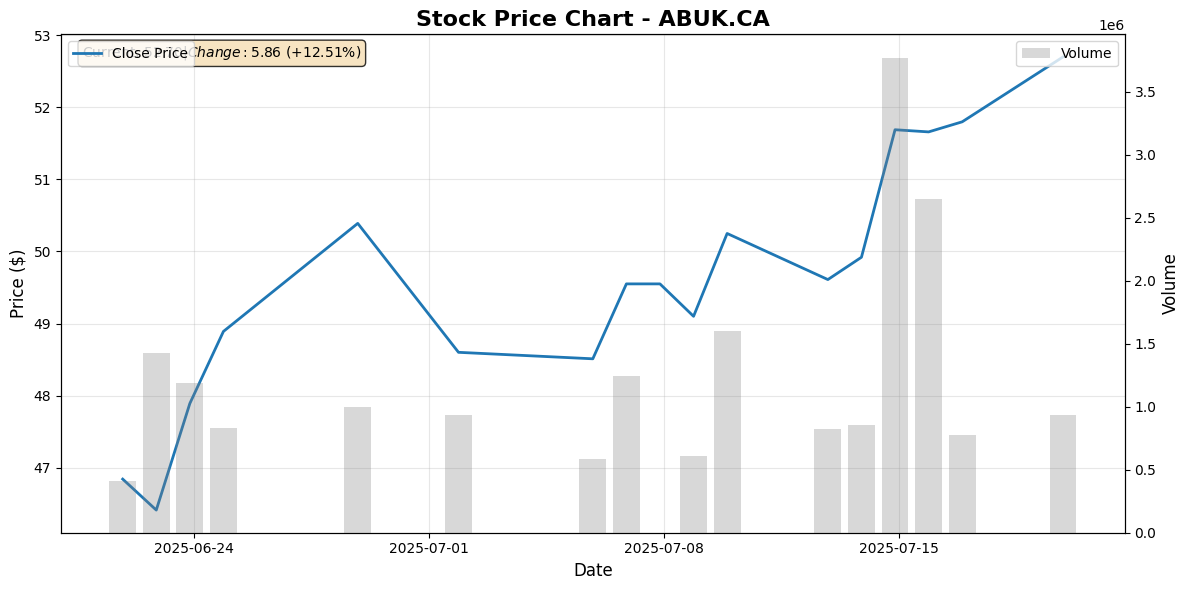

In [6]:
def plot_price(df, symbol):
    """
    Create a price chart using Matplotlib
    
    Args:
        df (pandas.DataFrame): Historical stock data
        symbol (str): Stock ticker symbol
    
    Returns:
        matplotlib.figure.Figure: Price chart figure
    """
    if df.empty:
        # Create empty figure with error message
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.text(0.5, 0.5, f'No data available for {symbol}', 
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=16)
        ax.set_title(f'Stock Price Chart - {symbol}')
        return fig
    
    try:
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot closing price
        ax.plot(df.index, df['Close'], linewidth=2, label='Close Price', color='#1f77b4')
        
        # Add volume as secondary axis
        ax2 = ax.twinx()
        ax2.bar(df.index, df['Volume'], alpha=0.3, color='gray', label='Volume')
        
        # Formatting
        ax.set_title(f'Stock Price Chart - {symbol}', fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Price ($)', fontsize=12)
        ax2.set_ylabel('Volume', fontsize=12)
        
        # Add grid
        ax.grid(True, alpha=0.3)
        
        # Format dates on x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        plt.xticks(rotation=45)
        
        # Add legends
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        # Add price statistics
        current_price = df['Close'].iloc[-1]
        price_change = df['Close'].iloc[-1] - df['Close'].iloc[0]
        price_change_pct = (price_change / df['Close'].iloc[0]) * 100
        
        stats_text = f'Current: ${current_price:.2f} | Change: ${price_change:.2f} ({price_change_pct:+.2f}%)'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                verticalalignment='top', fontsize=10)
        
        # Tight layout
        plt.tight_layout()
        
        return fig
        
    except Exception as e:
        # Create error figure
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.text(0.5, 0.5, f'Error creating chart: {str(e)}', 
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=16)
        ax.set_title(f'Stock Price Chart - {symbol}')
        return fig

# Test the plotting function
if not test_data.empty:
    print("\n📊 Creating test chart...")
    test_fig = plot_price(test_data, test_symbol)
    plt.show()


## 7. Gradio Chat Interface

This section creates the main Gradio interface with a two-column layout for stock analysis and Sharia compliance assessment.


In [7]:
def analyze_stock(symbol):
    """
    Main analysis function that combines all tools
    
    Args:
        symbol (str): Stock ticker symbol
    
    Returns:
        tuple: (trade_advice, sharia_dict, price_chart)
    """
    if not symbol or not symbol.strip():
        return ("Please enter a valid stock symbol.", {}, None)
    
    symbol = symbol.strip().upper()
    
    try:
        # Update status
        status_message = f"🔄 Analyzing {symbol}..."
        print(status_message)
        
        # Fetch data for multiple periods
        periods = ["1mo", "1y", "5y"]
        summaries = {}
        
        for period in periods:
            print(f"📈 Fetching {period} data...")
            df = fetch_history(symbol, period, "1d")
            if not df.empty:
                summaries[period] = summarize(df)
            else:
                summaries[period] = {"error": f"No data for {period}"}
        
        # Get 1-month data for chart
        df_1mo = fetch_history(symbol, "1mo", "1d")
        
        # Get trade advice
        print("🤖 Getting AI trade advice...")
        trade_advice = get_trade_advice(symbol, summaries)
        
        # Get Sharia assessment
        print("☪️ Assessing Sharia compliance...")
        sharia_assessment = assess_sharia(symbol)
        
        # Create price chart
        print("📊 Creating price chart...")
        price_chart = plot_price(df_1mo, symbol)
        
        print(f"✅ Analysis complete for {symbol}")
        
        return (trade_advice, sharia_assessment, price_chart)
        
    except Exception as e:
        error_msg = f"❌ Error analyzing {symbol}: {str(e)}"
        print(error_msg)
        return (error_msg, {"error": str(e)}, None)

# Create Gradio Interface
def create_interface():
    """Create and return the Gradio interface"""
    
    with gr.Blocks(title="Stock Analysis & Sharia Compliance", theme=gr.themes.Soft()) as interface:
        
        # Header
        gr.Markdown("""
        # 📈 Stock Analysis & Sharia Compliance Tool
        
        **Get comprehensive stock analysis with AI-powered trade recommendations and Islamic Sharia compliance assessment.**
        
        *Enter a stock ticker (e.g., AAPL, MSFT, GOOGL) and click Analyze to get started.*
        """)
        
        with gr.Row():
            # Left Column - Inputs and Results
            with gr.Column(scale=1):
                gr.Markdown("### 📊 Stock Analysis")
                
                # Input section
                with gr.Group():
                    ticker_input = gr.Textbox(
                        label="Stock Ticker Symbol",
                        placeholder="Enter ticker (e.g., AAPL, MSFT, GOOGL)",
                        value="AAPL"
                    )
                    analyze_button = gr.Button("🔍 Analyze Stock", variant="primary", size="lg")
                
                # Trade advice output
                with gr.Group():
                    gr.Markdown("### 🤖 AI Trade Recommendation")
                    trade_advice_output = gr.Textbox(
                        label="Trade Advice",
                        lines=8,
                        placeholder="AI trade recommendation will appear here..."
                    )
                
                # Sharia compliance output
                with gr.Group():
                    gr.Markdown("### ☪️ Sharia Compliance Assessment")
                    sharia_output = gr.JSON(
                        label="Sharia Ruling",
                        value={"ruling": "Not analyzed", "confidence": 0, "justification": "Click Analyze to assess"}
                    )
            
            # Right Column - Chart
            with gr.Column(scale=1):
                gr.Markdown("### 📈 Price Chart (1 Month)")
                chart_output = gr.Plot(
                    label="Stock Price Chart",
                    value=None
                )
        
        # Examples section
        with gr.Row():
            gr.Markdown("""
            ### 💡 Example Tickers to Try:
            - **AAPL** - Apple Inc. (Technology)
            - **MSFT** - Microsoft Corporation (Technology) 
            - **BRK-B** - Berkshire Hathaway (Conglomerate)
            - **JNJ** - Johnson & Johnson (Healthcare)
            - **BAC** - Bank of America (Banking - may be Haram)
            - **KO** - Coca-Cola (Beverages)
            
            *Note: Add ".CA" suffix for Canadian stocks (e.g., "SHOP.TO" for Toronto Stock Exchange)*
            """)
        
        # Wire up the interface
        analyze_button.click(
            fn=analyze_stock,
            inputs=[ticker_input],
            outputs=[trade_advice_output, sharia_output, chart_output],
            show_progress=True
        )
        
        # Add example buttons
        with gr.Row():
            example_buttons = [
                gr.Button("📱 AAPL", size="sm"),
                gr.Button("💻 MSFT", size="sm"),
                gr.Button("🏦 BAC", size="sm"),
                gr.Button("🥤 KO", size="sm")
            ]
        
        # Wire example buttons
        for button, ticker in zip(example_buttons, ["AAPL", "MSFT", "BAC", "KO"]):
            button.click(
                fn=lambda t=ticker: t,
                outputs=[ticker_input]
            )
    
    return interface

# Create the interface
print("🚀 Creating Gradio interface...")
demo = create_interface()

print("✅ Interface created successfully!")
print("🌐 Launch the interface by running: demo.launch()")


🚀 Creating Gradio interface...
✅ Interface created successfully!
🌐 Launch the interface by running: demo.launch()


## 8. Launch the Interface

Run the cell below to launch the Gradio interface. It will open in your browser and provide an interactive chat interface for stock analysis.


In [8]:
# Launch the Gradio interface
if __name__ == "__main__":
    print("🚀 Launching Stock Analysis & Sharia Compliance Interface...")
    print("📝 Make sure you have set your OPENAI_API_KEY environment variable")
    print("🌐 The interface will open in your browser")
    
    # Launch with sharing enabled for easy access
    demo.launch(
        share=True,  # Creates a public link for sharing
        server_name="0.0.0.0",  # Allow external access
        show_error=True,  # Show detailed error messages
        quiet=False  # Show startup logs
    )


🚀 Launching Stock Analysis & Sharia Compliance Interface...
📝 Make sure you have set your OPENAI_API_KEY environment variable
🌐 The interface will open in your browser
* Running on local URL:  http://0.0.0.0:7860
* Running on public URL: https://ebf42ba14d2f6c267b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
